# MRI-Based Brain Tumor Detection Using TensorFlow

## Import

In [118]:
import os
import matplotlib.pyplot as plt
from PIL import Image

## Data upload

Given dataset consists of 2 folders: **Training** and **Testing**, each containing 4 types of pictures - **glioma**, **meningioma**, **pituitary** and **no tumor**.  
  
Each picture has a resolution of **512x512 pixels** and has **grayscale** colormap.
  
**Training** has **1321**, **1339**, **1457**, **1595** pictures resp.  
**Testing** has **300**, **306**, **300**, **405** pictures resp.  
  
Thus, we can straight away make an assumption that dataset is slightly imbalanced.

## Visualization

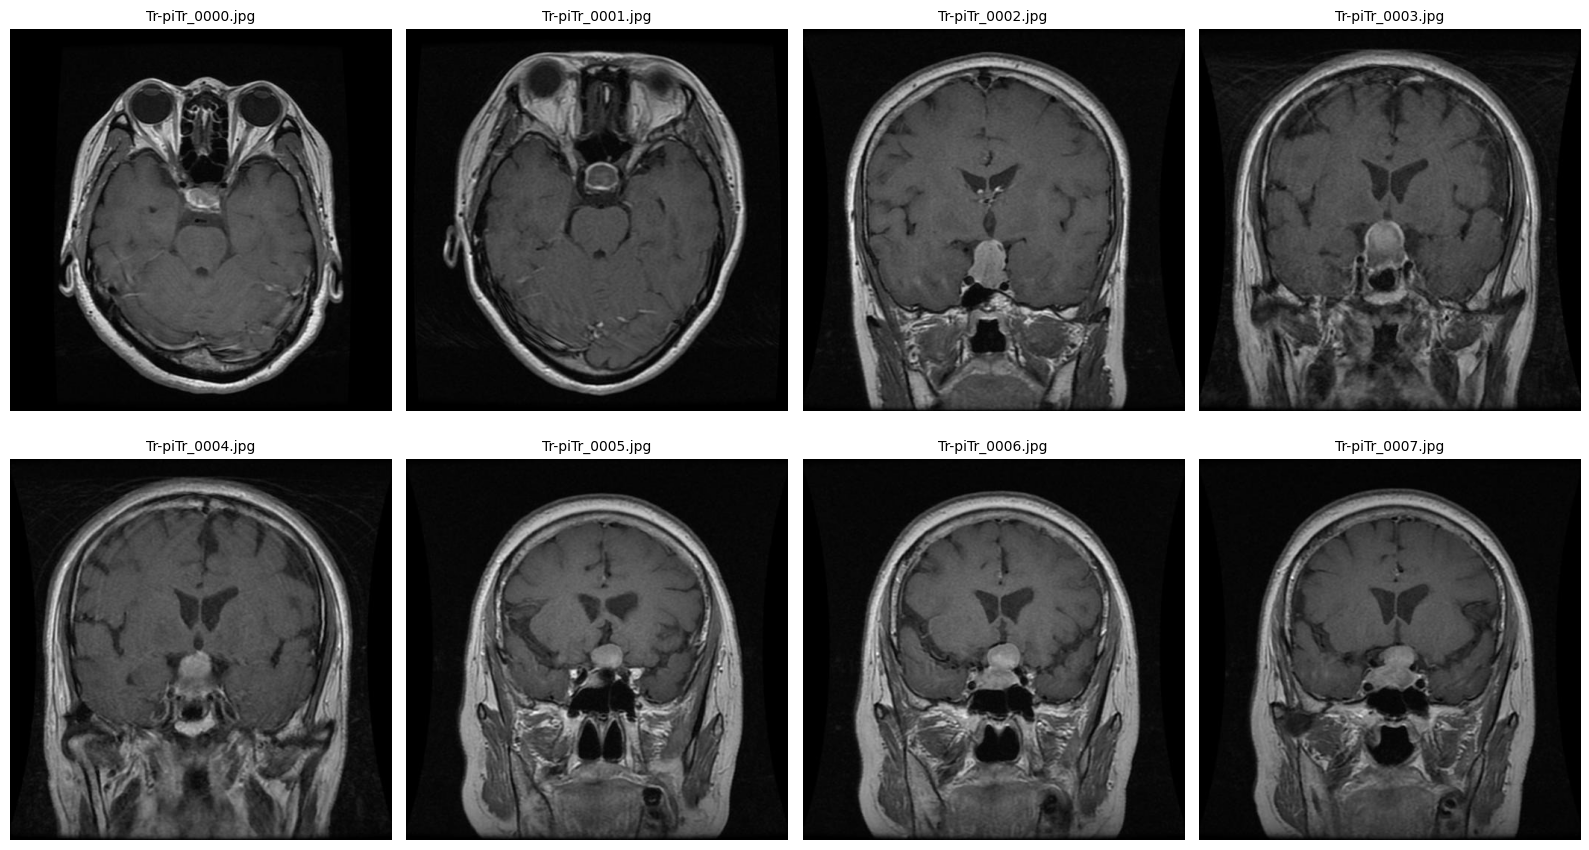

In [119]:
image_folder = '../data/raw/Training/pituitary'
image_filenames = [f for f in os.listdir(image_folder) if f.endswith('.jpg')]


fig, axes = plt.subplots(2, 4, figsize=(16, 9))
for ax, image_filename in zip(axes.flatten(), image_filenames):
    img_path = os.path.join(image_folder, image_filename)
    img = Image.open(img_path)
    ax.imshow(img)
    ax.set_title(image_filename, fontsize=10)
    ax.axis('off')

plt.tight_layout()
plt.show()

We can see that MRI scans are provided in different planes with different slice locations.

## Class distribution

!!! The simplest approach would be to combine all files into a single dataset and then split it into proportional batches for training, validation, and testing. However, to better reflect real-world scenarios, let’s assume the dataset is provided in a pre-split format (which is true). In this case, we need to manually verify the correctness of the distribution.

Let's now calculate distribuiton of classes to work with.  
First of all, we need to calculate the number of files in each *tumor-type* folder:

In [120]:
parent_folder = '../data/raw'
entries = os.listdir(parent_folder)
folders = [entry for entry in entries if os.path.isdir(os.path.join(parent_folder, entry))]

num_training = []
num_testing = []

for folder in folders:
    folder_path = os.path.join(parent_folder, folder)
    sub_entries = os.listdir(folder_path)
    subfolders = [sub_entry for sub_entry in sub_entries if os.path.isdir(os.path.join(folder_path, sub_entry))]
    for subfolder in subfolders:
        subfolder_path = os.path.join(folder_path, subfolder)
        num_files = len([f for f in os.listdir(subfolder_path) if f.endswith('.jpg')])
        if folder == 'testing':
            num_testing.append(num_files)
        elif folder == 'training':
            num_training.append(num_files)


Now we plot the ratio between the amount of train and test files, as well as train and test per-class ratio:

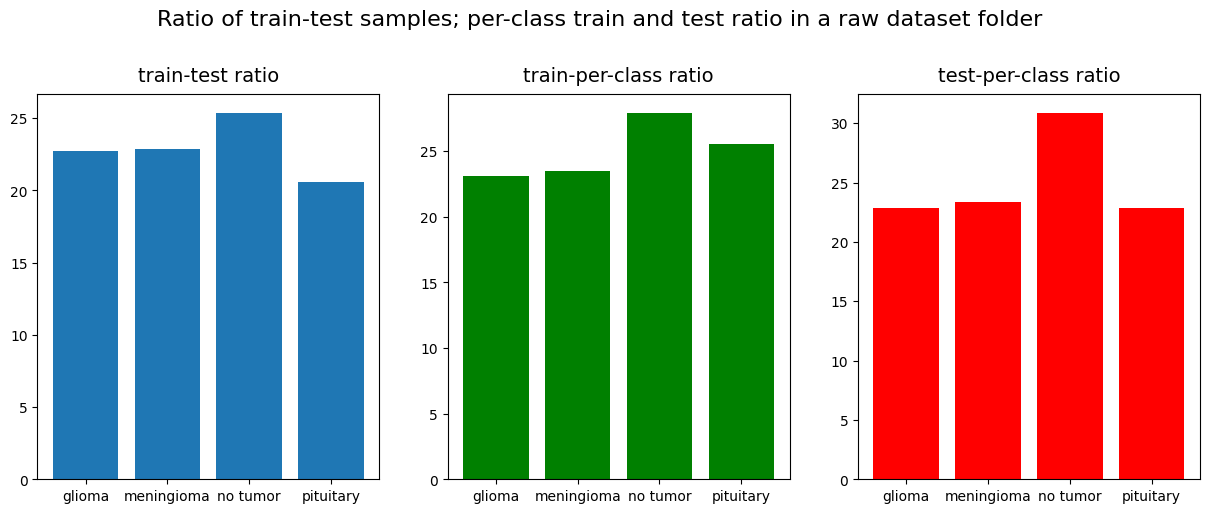

In [121]:
import numpy as np

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
train_test_ratio = []
x_ticks = ['glioma', 'meningioma', 'no tumor', 'pituitary']

for num_tr, num_tst in zip(num_training, num_testing):
    train_test_ratio.append((num_tst/num_tr)*100)

axes[0].bar(x_ticks, train_test_ratio)
axes[0].set_title('train-test ratio', fontsize=14, pad=20, verticalalignment='top');

train_ratio = [(value / sum(num_training)) * 100 for value in num_training]
test_ratio = [(value / sum(num_testing)) * 100 for value in num_testing]

axes[1].bar(x_ticks, train_ratio, color='green')
axes[1].set_title('train-per-class ratio', fontsize=14, pad=20, verticalalignment='top');

axes[2].bar(x_ticks, test_ratio, color='red')
axes[2].set_title('test-per-class ratio', fontsize=14, pad=20, verticalalignment='top');

fig.suptitle('Ratio of train-test samples; per-class train and test ratio in a raw dataset folder', fontsize=16, y=1.05);

We see that distribution is wrong in either case, so we will need to deal with this problem later in the preprocessing step.

## Conclusion

- Dataset has 4 distinct classes - **glioma**, **meningioma**, **pituitary** and **no tumor**.  
- Thus, it is a **multiclass classification** problem.  

- The number of samples throughout the classes is not consistent, so we will consider given dataset to be **imbalanced**.
  
- Since we are dealing with medical analysis, where the cost of false negative prediction is very high, we are going to use **Recall** as a main performance metric.